In [1]:
# Data structures
import numpy as np 
import pandas as pds

# Plotting
from matplotlib import pyplot as plt

# Web-scraping
import requests 
from io import StringIO 

# Vizier
from astroquery.vizier import Vizier

## SDSS

In [128]:
def fetch_patch(ra, dec): 
    
    # Note:
    # ra -> right ascension
    # dec -> declination
    
    ra_lower, ra_upper = ra
    dec_lower, dec_upper = dec
    
    # ra_lower -> lower right ascension bound
    # ra_upper -> upper right ascension bound
    # dec_lower -> lower declination bound
    # dec_upper -> upper declination bound
    
    # query -> the string being sent to the SkyServer database
    # You can find what all these variables mean on the site, 
    # You can also include more variables if desired.
    
    query = '''SELECT
       p.objid, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, p.cx, p.cy, p.cz,
       s.class, s.z as redshift
    FROM PhotoObj AS p
       JOIN SpecObj AS s ON s.bestobjid = p.objid
    WHERE 
       p.ra between {} and {} and
       p.dec between {} and {} and
       s.class = "STAR"
    '''.format(ra_lower, ra_upper, dec_lower, dec_upper)
    
    # The location of the site.
    url = 'http://skyserver.sdss.org/dr14/SkyServerWS/SearchTools/SqlSearch?cmd={}&format=csv'.format(query)
    
    # Making a request on the data.
    r = requests.get(url)
    
    # Check for a succesful result.
    if r.status_code == 200:
        
        # This creates a csv file from the text.
        csv = StringIO(r.text)
        
        # Making a dataframe, since operations on that are easier.
        df = pds.read_csv(csv, skiprows = 1)
        
        return df

In [185]:
# Start with something small, say, 1 degree across both.
ra = (0, 1)
dec = (0, 1)

sdss_df = fetch_patch(ra, dec).dropna()

In [186]:
sdss_df.keys()

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'cx', 'cy', 'cz',
       'class', 'redshift'],
      dtype='object')

In [189]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,cx,cy,cz,class,redshift
0,1237645942905897179,58.097962,0.101864,20.69693,18.00692,16.49571,15.70788,15.26716,0.528468,0.848952,0.001778,STAR,0.000203
1,1237645943978852701,56.236128,0.953291,25.16475,22.05796,20.39417,18.94487,18.16151,0.555695,0.831220,0.016637,STAR,-0.000020
2,1237645943978852860,56.184129,0.956829,24.42230,22.93605,21.03657,19.81199,19.05802,0.556448,0.830714,0.016699,STAR,0.000208
3,1237645943978917938,56.309292,0.916452,20.89159,19.68915,19.61545,19.67460,19.63020,0.554639,0.831938,0.015994,STAR,0.000201
4,1237645943979180313,57.043393,0.874964,23.17451,21.26408,19.57078,18.51824,17.92310,0.543940,0.838985,0.015270,STAR,-0.000018


## VIZIER

In [104]:
def get_catalog(item):
    return list(Vizier.find_catalogs(item))

In [6]:
qry = get_catalog('V/19')

In [42]:
vizier_dfs = Vizier.query_constraints(qry[1])

In [218]:
vizier_df = vizier_dfs[0].to_pandas().select_dtypes(exclude=['object'])

In [219]:
vizier_df.keys()

Index(['Per', 'qph', 'f', 'T1', 'T2', '_RA', '_DE'], dtype='object')

In [222]:
vizier_df.head()

,Per,qph,f,T1,T2,_RA,_DE
0,0.331891,0.491,0.15,5450.0,5821.0,347.8837,36.8931
1,0.610113,0.497,0.08,6800.0,4500.0,32.2643,40.7942
2,0.462791,0.450,0.43,6200.0,4680.0,5.1273,40.2261
3,0.404111,0.340,0.39,5960.0,6073.0,25.6222,44.7618
4,0.305018,NaN,NaN,NaN,NaN,33.0595,44.6610


## Join the two

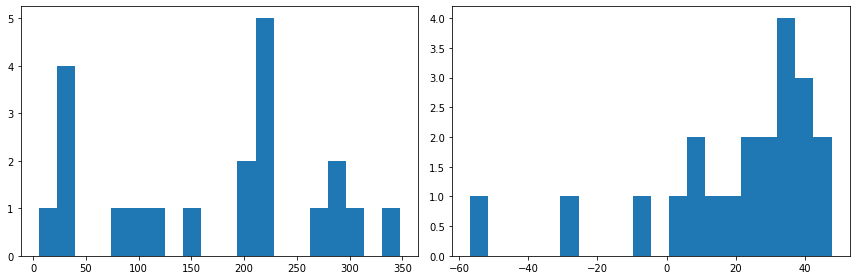

In [64]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(vizier_df['_RA'], 20)
ax[1].hist(vizier_df['_DE'], 20)

fig.tight_layout();

In [231]:
sdss_vizier = pds.merge(sdss_df, vizier_df, how='left', left_on=['ra', 'dec'], right_on = ['_RA', '_DE']).dropna()

In [229]:
sdss_vizier.head()

,objid,ra,dec,u,g,r,i,z,cx,cy,cz,class,redshift,Per,qph,f,T1,T2,_RA,_DE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331891,0.491,0.15,5450.0,5821.0,347.8837,36.8931
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.610113,0.497,0.08,6800.0,4500.0,32.2643,40.7942
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.462791,0.450,0.43,6200.0,4680.0,5.1273,40.2261
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404111,0.340,0.39,5960.0,6073.0,25.6222,44.7618
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.305018,NaN,NaN,NaN,NaN,33.0595,44.6610


In [212]:
vizier_sort = np.array(np.argsort(-vizier_df['_RA']))

In [213]:
sdss_sort = np.array(np.argsort(-sdss_df['ra']))

In [214]:
np.array(vizier_df['_RA'])[vizier_sort][0] - np.array(sdss_df['ra'])[sdss_sort][0]

0.0003670225519840642

In [215]:
np.array(vizier_df['_DE'])[vizier_sort][0] - np.array(sdss_df['dec'])[sdss_sort][0]

36.63140006202746

In [216]:
np.array(vizier_df['_DE'])[vizier_sort]

array([ 36.8931,   9.309 ,   5.8382,  -7.485 , -56.8215,  47.6541,
        35.1333,   9.1137,  12.5676,  30.    ,  20.1902,  24.9233,
       -28.6278,  36.448 ,  27.999 ,  33.3977,  40.7942,  24.0017,
        37.8064,  44.7618,  40.2261])

In [217]:
np.array(vizier_df['_RA'])[vizier_sort]

array([347.8837, 297.0527, 293.8505, 285.1875, 264.5231, 225.9471,
       225.1958, 218.7657, 214.3585, 211.2458, 207.2982, 207.0458,
       143.0766, 110.9594,  96.5206,  76.9997,  32.2643,  31.0625,
        29.4879,  25.6222,   5.1273])

In [202]:
np.array(sdss_df['ra'])[sdss_sort]

array([  5.12736031,   5.12779091,   5.12806729, ..., 347.88299326,
       347.88321375, 347.88333298])